In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import Variable

Below I have defined a regressor class that defines our neural network that we will be using for this algorithm. This neural network is simply a series of fully conencted layers that uses Relu activation function for the hidden layers and a linear activation at the final layer. I have also defined a plot function that will plot the predicted points from a task. It'll be useful to see how well the model generalizes to new tasks.

In [2]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        hiddenUnits = 40
        inputDim = outputDim = 1 
        self.fc1 = nn.Linear(inputDim,hiddenUnits)
        self.fc2 = nn.Linear(hiddenUnits,hiddenUnits)
        self.fc3 = nn.Linear(hiddenUnits, outputDim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def plot(self, task, *args, **kwargs):
        task.plot()
        x, _ = task.samplePointsFromTest()
        x = Variable(x[:, None])
        y_pred = self.forward(x)
        plt.plot(x.numpy(), y_pred.detach().numpy(), *args, **kwargs)

The SineTask below generates a random sine wave which has an amplitude between 0.1 and 5 and a phase angle between 0 and $\pi$. We use this function to sample sine waves that will be used for meta learning. When sampling points from during training, we uniformly sample coordinates along the x axis between -5 to 5 and we use the evaluateSine function to get the corresponding points on the y axis. Below you can see that everytime we create a new SineTask object, we get a different sine wave with a different amplitude and phase. 

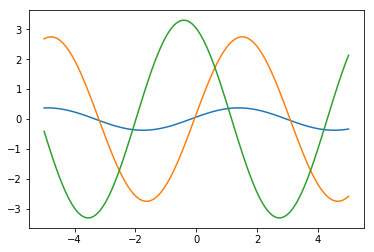

In [3]:
class SineTask():
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
        self.xRangeMin = -5
        self.xRangeMax = 5
    
    def samplePointsFromTraining(self,numPoints=10):
        x = np.random.uniform(self.xRangeMin, self.xRangeMax,size=numPoints)
        return torch.Tensor(x), torch.Tensor(self.evaluateSine(x))
    
    def evaluateSine(self, sampledPoints):
        return self.amplitude*np.sin(sampledPoints + self.phase)   
    
    def samplePointsFromTest(self, numPoints=50):
        x = np.linspace(self.xRangeMin, self.xRangeMax, numPoints)
        return torch.Tensor(x), torch.Tensor(self.evaluateSine(x))

    def plot(self, *args, **kwargs):
        x, y = self.samplePointsFromTest(numPoints=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
        

SineTask().plot()
SineTask().plot()
SineTask().plot()
plt.show()     

Now that the sine wave tasks have been defined, we can now start defining the tasks for the Reptile meta learning algorithm. Reptile is very similar to first order MAML defined by Finn. The algorithm goes as follows. 

For Reptile, first initialize a paramater vector. In our case, create a neural network with parameter $\Phi$. Note $\Phi$ is not chosen beforehand, it is just the paramaters of the neural network at initialization. 

Then for a certain number of meta-iterations, sample a task then take perform SGD for K steps. In this step, you create a secondary model that initially has parameter $\Phi$ but then as you perform K steps of SGD the paramaters transform from $\Phi$ to $\Omega$. 

Once you have perform K steps of SGD, the original neural network with paramaters $\Phi$ is updated using the following equation: 
$\Phi = \Phi + \epsilon(\Omega - \Phi)$

Then update the model with the new updated parameter $\Phi$.

After repeating this tasks for the number of meta-iterations defined, you return the model with the updated parameters $\Phi$.

Below is the Reptile procedure that takes in a model with paramater $\Phi$ and we define the total number of metaIteratios, the training set size, and a validation set size to see how well the model generalizes. We use an Adam optimizer for the meta learning and SGD for taking K steps. Furthermore we also define how many gradient steps, K, to take along with the update factor $\epsilon$. In this procedure, we evaluate how well the model generalizes with the validations set by taking K gradient steps and then measuring the overall loss obtained. 

In [7]:
def reptileProcedure(model, totalIteration, trainingSetSize, valSetSize, lr_inner, lr_outer, K, epsilon):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_outer)
    training_loss = []
    validation_loss = []
    
    trainingSet = [SineTask() for _ in range(trainingSetSize)]
    valSet = [SineTask() for _ in range(valSetSize)]

    for iteration in range(totalIteration): 
        sampled_task = random.sample(trainingSet, 1)[0] #sample a task from all training tasks
        #take k gradient steps
        newModel = takeGradientSteps(model, sampled_task, lr_inner, K)
        #from new model update model with new params
        for currParams, newParams in zip(model.parameters(), newModel.parameters()):
            if currParams.grad is None: #if gradient doesn't exist or not initialized 
                currParams.grad = Variable(torch.zeros(newParams.size())) #initialize the params for update
            currParams.grad.data.add_(epsilon*(currParams.data - newParams.data)) #(update)
        #update the model parameters, take step first 
        #as loss is based on the loss from learner
        optimizer.step()
        #set optimizer to zero for next iteration of learning 
        optimizer.zero_grad()
        #evaluate meta learning loss on training and validation set
        training_loss.append(evaluateModel(newModel, sampled_task))
        validationTask = random.sample(valSet, 1)[0]
        newModel = takeGradientSteps(model, validationTask, lr_inner, K)
        validation_loss.append(evaluateModel(newModel, validationTask))
        #during validation, we are testing to see how well the model adjusts to an unseen task after 
        #k gradient steps
        if iteration % 1000 == 0:
            print('iteration ' + str(iteration) + " avg training_loss: " + str(np.mean(training_loss)))
            print('iteration ' + str(iteration) + " avg validation_loss: " + str(np.mean(validation_loss)))
    return model 

In the method seen below, we take in the model with parameter $\Phi$, the sampled task, the learning rate, and K which dictates how many times we perform SGD. Since this task is to predict the points along a sine wave, we use an MSE loss. The procedure below creates a new model and then initializes the new model with parameters $\Phi$. I then perform K rounds of SGD optimization on the sampled task before returning a new model with parameters $\Omega$

In [4]:
def takeGradientSteps(model, sampled_task, lr_inner, K, plotResult=False,*args, **kwargs):
    new_model = Regressor()
    #new model parameters equal to initial model parameters 
    new_model.load_state_dict(model.state_dict()) 
    loss = nn.MSELoss()
    inner_optimizer = torch.optim.SGD(new_model.parameters(), lr=lr_inner)
    #take K gradient steps and perform SGD to update parameters 
    for k in range(K): 
        x,y_ground = sampled_task.samplePointsFromTraining()
        x = Variable(x[:, None]) #pass x and y as column vector
        y = Variable(y_ground[:, None])
        y_pred = new_model(x)
        mseLoss = loss(y_pred, y)
        inner_optimizer.zero_grad()
        mseLoss.backward()
        inner_optimizer.step()
    return new_model

The method below, takes in the current model and then evaluates the MSE loss obtained between the predicted points from the model and the ground truth points. 

In [5]:
def evaluateModel(model, task):
    x, y = task.samplePointsFromTest()
    x = Variable(x[:,None])
    y = Variable(y[:,None])
    y_pred = model(x)
    loss_func = nn.MSELoss()
    return loss_func(y, y_pred).data

Below we perform the meta learning by first defining all the hyperparameters needed for this procedure and then running the Reptile procedure. I have printed the training set loss and validation loss after every 1000 meta iterations. You can see below that both the training loss and validation loss decreases significantly over time.    

In [8]:
metaIterations = 100000
K = 10
lr_inner=0.01
lr_outer=0.001
training_set_size = 10000
test_set_size = 1000
overallModel = Regressor()
epsilon = 1
meta_learned_model = reptileProcedure(overallModel,metaIterations,training_set_size,test_set_size,lr_inner,lr_outer, K, epsilon)

iteration 0 avg training_loss: 7.305396
iteration 0 avg validation_loss: 0.1824821
iteration 1000 avg training_loss: 1.5666094
iteration 1000 avg validation_loss: 1.4971606
iteration 2000 avg training_loss: 1.0884101
iteration 2000 avg validation_loss: 1.0359132
iteration 3000 avg training_loss: 0.8585938
iteration 3000 avg validation_loss: 0.79595894
iteration 4000 avg training_loss: 0.70460236
iteration 4000 avg validation_loss: 0.66326606
iteration 5000 avg training_loss: 0.6001728
iteration 5000 avg validation_loss: 0.56686664
iteration 6000 avg training_loss: 0.52515763
iteration 6000 avg validation_loss: 0.49797854
iteration 7000 avg training_loss: 0.46754706
iteration 7000 avg validation_loss: 0.44234914
iteration 8000 avg training_loss: 0.4225347
iteration 8000 avg validation_loss: 0.39856204
iteration 9000 avg training_loss: 0.38294908
iteration 9000 avg validation_loss: 0.36197028
iteration 10000 avg training_loss: 0.35119152
iteration 10000 avg validation_loss: 0.33320013
it

iteration 87000 avg validation_loss: 0.054990664
iteration 88000 avg training_loss: 0.056576233
iteration 88000 avg validation_loss: 0.054507613
iteration 89000 avg training_loss: 0.05607722
iteration 89000 avg validation_loss: 0.054032773
iteration 90000 avg training_loss: 0.05559463
iteration 90000 avg validation_loss: 0.053564187
iteration 91000 avg training_loss: 0.055120848
iteration 91000 avg validation_loss: 0.053112257
iteration 92000 avg training_loss: 0.054661345
iteration 92000 avg validation_loss: 0.052663118
iteration 93000 avg training_loss: 0.05419912
iteration 93000 avg validation_loss: 0.05222197
iteration 94000 avg training_loss: 0.0537509
iteration 94000 avg validation_loss: 0.05179878
iteration 95000 avg training_loss: 0.053318966
iteration 95000 avg validation_loss: 0.051380243
iteration 96000 avg training_loss: 0.052893396
iteration 96000 avg validation_loss: 0.05097206
iteration 97000 avg training_loss: 0.05247278
iteration 97000 avg validation_loss: 0.05056754
i

Once we get the meta learned model from performing Reptile procedure, below we can visualize how well this model generalizes to unseen sine wave variables. We can see that after taking only 4 gradient steps, the model is able to almost perfectly predict all points along the unseen sine wave. 

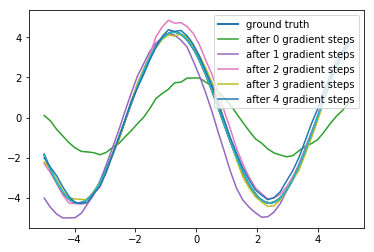

In [10]:
testTask = SineTask()
testTask.plot(label='ground truth', linewidth=2.0)
meta_learned_model.plot(testTask, label="after " + str(0) + " gradient steps")
for k in range(1,5):
    new_model = takeGradientSteps(meta_learned_model, testTask, lr_inner, K=k, plotResult=True )
    labelk = "after " + str(k) + " gradient steps"
    new_model.plot(testTask, label=labelk)
plt.legend()